In [1]:
import numpy as np
import pandas as pd
import transformers
import torch
from torch import nn
from torch.utils.data import DataLoader
from datasets import NewsHeadlinesDataset
from model import SarcasmDetectionModel
from util import train_model, plot_loss, plot_accuracies, get_failed_examples, save_failed_examples

import warnings
warnings.filterwarnings("ignore")

In [14]:
# Global Variables
device = "cuda" if torch.cuda.is_available() else "cpu"
news_dataset_dir = "Sarcasm_Headlines_Dataset_v2.json"
split_ratio = 0.8
model_save_path = "model.pth"
loss_save_path = "losses.png"
acc_save_path = "accuracies.png"
failed_examples_save_path = "failed_examples.json"

# Hyperparameters
len_dataset = 6000
batch_size = 64
lr = 3e-6
n_epoch = 20

In [3]:
# Load the data and shuffle it
print("Loading data...")
news_dataset = pd.read_json(news_dataset_dir, lines=True)
news_dataset = news_dataset[:len_dataset]
news_dataset = news_dataset.sample(frac=1).reset_index(drop=True)
print(f"Instances of each sample in the entire dataset: {news_dataset['is_sarcastic'].value_counts()}")

Loading data...
Instances of each sample in the entire dataset: is_sarcastic
0    3096
1    2904
Name: count, dtype: int64


In [4]:
# Load the pre-trained BERT model
model_class, tokenizer_class, pretrained_weights = (transformers.BertModel, transformers.BertTokenizer, "bert-base-uncased")
# model_class, tokenizer_class, pretrained_weights = (transformers.DistilBertModel, transformers.DistilBertTokenizer, "distilbert-base-uncased")

tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
bert_model = model_class.from_pretrained(pretrained_weights)

In [5]:
# Tokenize the dataset
tokenized_dataset_news = news_dataset["headline"].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

# Padding to match the shapes of all the input data
max_len = 0
for i in tokenized_dataset_news.values:
    if len(i) > max_len:
        max_len = len(i)

padded_dataset_news = np.array([i + [0]*(max_len-len(i)) for i in tokenized_dataset_news.values])
print(f"Shape of the padded dataset: {np.array(padded_dataset_news).shape}")

Shape of the padded dataset: (6000, 56)


In [6]:
# Add a mask so that the model doesn't consider padded tokens
attention_mask_news = np.where(padded_dataset_news != 0, 1, 0)
print(f"Shape of the masked dataset: {attention_mask_news.shape}")

Shape of the masked dataset: (6000, 56)


In [7]:
# Split the data in training and testing sets and create dataloaders
split_val = int(split_ratio*len_dataset)
print(f"Splitting the data -> Train ({split_val}) & Test ({len_dataset-split_val})")

train_features_news = torch.tensor(padded_dataset_news[:split_val], device=device).long()
train_mask_news = torch.tensor(attention_mask_news[:split_val], device=device).long()
train_labels_news = torch.tensor(news_dataset["is_sarcastic"].values[:split_val], device=device).long()
train_articles_news = news_dataset["article_link"].values[:split_val]
train_dataset_news = NewsHeadlinesDataset(train_features_news, train_mask_news, train_labels_news, train_articles_news)
train_loader_news = DataLoader(train_dataset_news, batch_size=batch_size, shuffle=True)

test_features_news = torch.tensor(padded_dataset_news[split_val:], device=device).long()
test_mask_news = torch.tensor(attention_mask_news[split_val:], device=device).long()
test_labels_news = torch.tensor(news_dataset["is_sarcastic"].values[split_val:], device=device).long()
test_articles_news = news_dataset["article_link"].values[split_val:]
test_dataset_news = NewsHeadlinesDataset(test_features_news, test_mask_news, test_labels_news, test_articles_news)
test_loader_news = DataLoader(test_dataset_news, batch_size=batch_size)

print(f"Instances of each sample in the train set: {news_dataset[:split_val]['is_sarcastic'].value_counts()}")
print(f"Instances of each sample in the test set: {news_dataset[split_val:]['is_sarcastic'].value_counts()}")

Splitting the data -> Train (4800) & Test (1200)
Instances of each sample in the train set: is_sarcastic
0    2500
1    2300
Name: count, dtype: int64
Instances of each sample in the test set: is_sarcastic
1    604
0    596
Name: count, dtype: int64


In [8]:
# Define the model, optimizer and the loss function
model = SarcasmDetectionModel(bert_model).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
loss_function = nn.CrossEntropyLoss()

In [9]:
# Create arrays to document progress
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

In [10]:
# Train and Evaluate the model
for epoch in range(n_epoch):
    train_loss, train_acc, test_loss, test_acc = train_model(model, optimizer, loss_function, train_loader_news, len(train_labels_news), test_loader_news, len(test_labels_news), epoch)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

Epoch 0 -> Train loss: 0.6503 Train acc: 60.38% Test acc: 79.75%
Epoch 1 -> Train loss: 0.4523 Train acc: 79.83% Test acc: 81.83%
Epoch 2 -> Train loss: 0.3538 Train acc: 85.54% Test acc: 84.00%
Epoch 3 -> Train loss: 0.2908 Train acc: 88.40% Test acc: 84.42%
Epoch 4 -> Train loss: 0.2495 Train acc: 90.52% Test acc: 85.50%
Epoch 5 -> Train loss: 0.2065 Train acc: 92.15% Test acc: 87.00%
Epoch 6 -> Train loss: 0.1817 Train acc: 93.19% Test acc: 87.50%
Epoch 7 -> Train loss: 0.1462 Train acc: 94.81% Test acc: 87.50%
Epoch 8 -> Train loss: 0.1308 Train acc: 95.48% Test acc: 87.33%
Epoch 9 -> Train loss: 0.1011 Train acc: 96.54% Test acc: 88.17%
Epoch 10 -> Train loss: 0.0868 Train acc: 97.25% Test acc: 87.08%
Epoch 11 -> Train loss: 0.0783 Train acc: 97.58% Test acc: 88.25%
Epoch 12 -> Train loss: 0.0607 Train acc: 98.23% Test acc: 87.83%
Epoch 13 -> Train loss: 0.0532 Train acc: 98.25% Test acc: 87.83%
Epoch 14 -> Train loss: 0.0445 Train acc: 98.81% Test acc: 87.92%
Epoch 15 -> Train lo

In [11]:
# Save the model
torch.save(model.state_dict(), model_save_path)

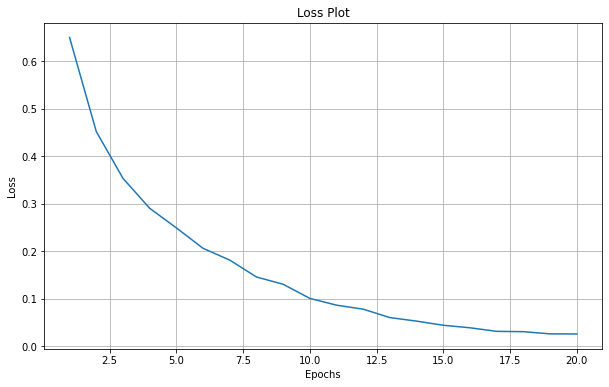

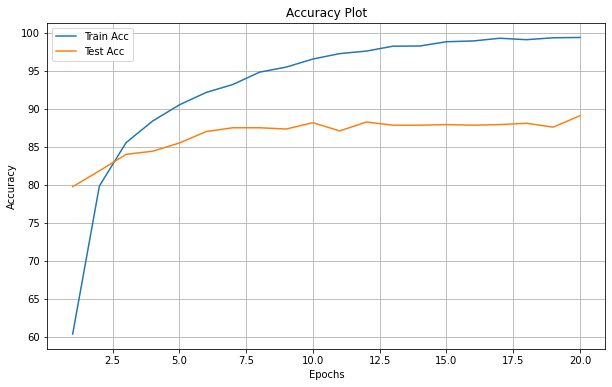

In [12]:
# Plot the results
plot_loss(train_losses, "Loss Plot", "Train Loss", "Loss", loss_save_path)
plot_accuracies(train_accuracies, test_accuracies, "Accuracy Plot", "Train Acc", "Test Acc", "Accuracy", acc_save_path)

In [15]:
# Get failed examples
failed_examples = get_failed_examples(model, test_loader_news, tokenizer)
save_failed_examples(failed_examples, failed_examples_save_path)